<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/5_Find_Best_Traffic_Flow_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this section of the code, we train two discrete Machine Learning models with the purpose of forecasting traffic flow along every path we defined earlier.**

The models that we use are: Long Short-Term Memory (LSTM) Recurent Neural Network (RNN) and an XGBoost regressor.

In this code file, we use only the traffic flow data that were generated under the SPQ rules.

In [3]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timestamp data types
from datetime import datetime, timedelta

In [4]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define the path with the data that we are interested in
PATH = '/content/drive/MyDrive/Paper/Timeseries/traffic_flow_SPQ.csv'

**Prepare the dataset**

We use the necessary code to convert our time series dataframe into more usefull one.

In [6]:
# Read the time series dataset
traffic_flow = pd.read_csv(PATH)

# This list contains the column names
columns = ["Taxi ID", "Traj ID", "Path", "Length"]

# Generate the columns for the dataset
i = 4

while(True):
    # If it is the first iteration, append the initial timestamp
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        # Append the next timestamp by adding 30 minutes (1800 seconds) to the previous timestamp
        columns.append(columns[i-1] + timedelta(seconds=1800))

    # Check if the current timestamp is greater than or equal to a specific end timestamp
    if (columns[i] >= pd.to_datetime('2008-05-30 00:00:04')):

        # Break out of the loop if the condition is met
        break

    # Increment the counter
    i += 1

# Delete the last timestamp
columns.pop()

# Assign new column names to the dataframe
traffic_flow.columns = columns

In [7]:
# Print first 2 rows of dataframe
traffic_flow.head(2)

,Taxi ID,Traj ID,Path,Length,2008-05-17 10:00:04,2008-05-17 10:30:04,2008-05-17 11:00:04,2008-05-17 11:30:04,2008-05-17 12:00:04,2008-05-17 12:30:04,...,2008-05-29 19:00:04,2008-05-29 19:30:04,2008-05-29 20:00:04,2008-05-29 20:30:04,2008-05-29 21:00:04,2008-05-29 21:30:04,2008-05-29 22:00:04,2008-05-29 22:30:04,2008-05-29 23:00:04,2008-05-29 23:30:04
0,426,1539,"[88597575, 417101708, 417101708, 620169771, 62...",7,1,1,0,0,1,1,...,9,8,8,8,12,8,5,4,3,5
1,372,160,"[714016923, 713758735, 713758735, 713758728, 7...",19,3,1,2,0,0,2,...,1,1,1,1,1,2,3,2,0,1


In [8]:
# Reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = traffic_flow.iloc[:,2:].columns
traffic_flow = traffic_flow.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
traffic_flow['Time Column'] = pd.to_datetime(traffic_flow['Time Column'])

# Sort rows by Path and Time
traffic_flow.sort_values(by=['Path','Time Column'],inplace=True)

**Convert 'Path' column to numerical**

In [9]:
# Use label encoder
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
traffic_flow['Path'] = label_encoder.fit_transform(traffic_flow['Path'])

# Sort the data based in Path column
traffic_flow = traffic_flow.sort_values(by=['Path','Time Column'])

**Use weather data**

In [10]:
# Define the path of weather data
path2 = '/content/drive/MyDrive/Paper/Datasets/Weather Data/weather_data.csv'

# Read weather data
weather_data = pd.read_csv(path2,sep=',')

Delete columns that contain Null values

In [11]:
# Find columns with Null values
weather_data.isna().sum()

name                  0
datetime              0
temp                  0
feelslike             0
dew                   0
humidity              0
precip                0
precipprob            0
preciptype          743
snow                  0
snowdepth             0
windgust            615
windspeed             0
winddir               5
sealevelpressure      0
cloudcover            0
visibility            0
solarradiation      744
solarenergy         744
uvindex             744
severerisk          744
conditions            0
icon                  0
stations              0
dtype: int64

In [12]:
# Drop columns with Null values
weather_data.drop(['preciptype','windgust','winddir','solarradiation','solarenergy','uvindex','severerisk'],axis=1,inplace=True)

In [13]:
# Summary statistics about the columns remained
weather_data.describe()

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,sealevelpressure,cloudcover,visibility
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.0,744.0,744.000000,744.000000,744.000000,744.000000
mean,14.306452,14.104435,8.050403,68.371653,0.000069,0.134409,0.0,0.0,18.272984,1014.920833,52.407392,15.372312
std,4.562143,4.642520,1.860187,15.086133,0.001870,3.666178,0.0,0.0,9.256835,4.181139,33.211088,1.368866
min,6.800000,5.600000,0.900000,20.370000,0.000000,0.000000,0.0,0.0,0.000000,997.100000,0.000000,6.200000
25%,11.300000,11.300000,6.800000,59.867500,0.000000,0.000000,0.0,0.0,11.375000,1013.900000,28.100000,15.075000
50%,13.050000,13.050000,7.900000,70.985000,0.000000,0.000000,0.0,0.0,17.300000,1015.800000,49.350000,16.000000
75%,16.300000,16.300000,9.100000,80.252500,0.000000,0.000000,0.0,0.0,24.625000,1017.325000,87.400000,16.000000
max,35.600000,33.800000,14.000000,94.340000,0.051000,100.000000,0.0,0.0,52.200000,1021.400000,100.000000,16.000000


In [14]:
# Delete columns that repeat the same value in the majority of the records, thus do not offer valueable information
weather_data.drop(['precip','precipprob','snow','snowdepth','sealevelpressure','visibility'],axis=1,inplace=True)

<Axes: >

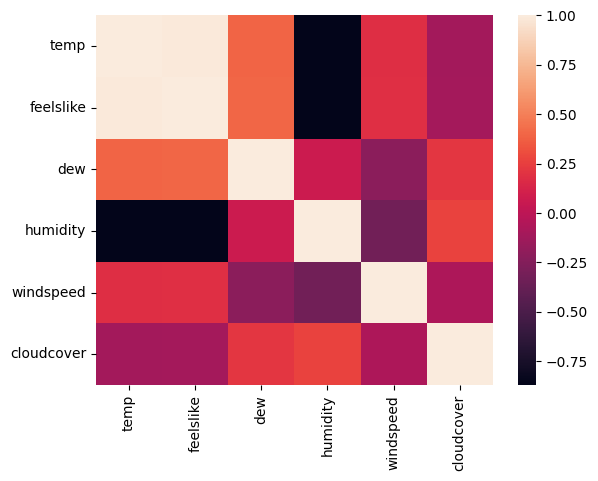

In [15]:
# Plot a heatmap of the remained columns
# Find highly correlated data
sns.heatmap(weather_data.corr())

In [16]:
# Based on the heatmap above, we remove highly correlated attributes: 'feelslike' and 'huidity'
weather_data.drop(['feelslike','humidity'],axis=1,inplace=True)

In [17]:
# Print weather data
weather_data

,name,datetime,temp,dew,windspeed,cloudcover,conditions,icon,stations
0,san francisco california,2008-05-01T00:00:00,9.6,4.4,14.8,0.0,Clear,clear-night,"72493023230,72495593227,72494023234"
1,san francisco california,2008-05-01T01:00:00,9.4,4.5,8.3,0.0,Clear,clear-night,"72493023230,72495593227,72494023234"
2,san francisco california,2008-05-01T02:00:00,9.2,4.0,10.7,14.3,Clear,clear-night,"72493023230,72495593227,72494023234"
3,san francisco california,2008-05-01T03:00:00,8.4,4.0,11.6,0.0,Clear,clear-night,"72493023230,72495593227,72494023234"
4,san francisco california,2008-05-01T04:00:00,7.9,3.8,5.8,0.0,Clear,clear-night,"72493023230,72495593227,72494023234"
...,...,...,...,...,...,...,...,...,...
739,san francisco california,2008-05-31T19:00:00,12.8,8.4,24.8,84.2,Partially cloudy,partly-cloudy-day,"72493023230,72495593227,72494023234"
740,san francisco california,2008-05-31T20:00:00,11.8,8.4,21.2,89.0,Partially cloudy,partly-cloudy-day,"72493023230,72495593227,72494023234"
741,san francisco california,2008-05-31T21:00:00,11.8,8.4,18.6,89.0,Partially cloudy,partly-cloudy-night,"72493023230,72495593227,72494023234"
742,san francisco california,2008-05-31T22:00:00,11.9,8.4,20.1,89.0,Partially cloudy,partly-cloudy-night,"72493023230,72495593227,72494023234"


In [18]:
# Drop 'name' and 'stations' attributes, as they do not offer something valuable
weather_data.drop(['name','stations'],axis=1,inplace=True)

In [19]:
# We choose to remove categorical values: 'conditions' and 'icon'
# One-Hot encoding these attributes will produce new columns with many zero values. LSTM RNN model may struggle to find patterns on that data.
weather_data.drop(['conditions','icon'],axis=1,inplace=True)

In [20]:
# Print weather dataset
weather_data

,datetime,temp,dew,windspeed,cloudcover
0,2008-05-01T00:00:00,9.6,4.4,14.8,0.0
1,2008-05-01T01:00:00,9.4,4.5,8.3,0.0
2,2008-05-01T02:00:00,9.2,4.0,10.7,14.3
3,2008-05-01T03:00:00,8.4,4.0,11.6,0.0
4,2008-05-01T04:00:00,7.9,3.8,5.8,0.0
...,...,...,...,...,...
739,2008-05-31T19:00:00,12.8,8.4,24.8,84.2
740,2008-05-31T20:00:00,11.8,8.4,21.2,89.0
741,2008-05-31T21:00:00,11.8,8.4,18.6,89.0
742,2008-05-31T22:00:00,11.9,8.4,20.1,89.0


In [21]:
# Convert datetime column to appropriate format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

In [22]:
# Connect two dataframes, time-series traffic flow and weather data
traffic_flow.set_index('Time Column', inplace=True)
weather_data.set_index('datetime', inplace=True)

In [23]:
# Resample the 'weather_data' dataset to 30-minute intervals and forward-fill the missing values
weather_data = weather_data.resample('30T').ffill()

# Add 4 seconds to each timestamp
weather_data.index = weather_data.index + pd.to_timedelta(4, unit='s')

In [24]:
# Merge the 'traffic_flow' and 'weather_data' datasets based on their indexes
traffic_flow = traffic_flow.merge(weather_data, left_index=True, right_index=True)

In [25]:
# Reset index and rename index column
traffic_flow = traffic_flow.reset_index()
traffic_flow.rename(columns={'index': 'Time Column'}, inplace=True)

In [26]:
# Print dataframe
traffic_flow

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,temp,dew,windspeed,cloudcover
0,2008-05-17 10:00:04,424,127,0,7,5,21.4,11.8,12.1,28.1
1,2008-05-17 10:00:04,72,145,1,15,0,21.4,11.8,12.1,28.1
2,2008-05-17 10:00:04,531,28,2,16,0,21.4,11.8,12.1,28.1
3,2008-05-17 10:00:04,23,346,3,15,2,21.4,11.8,12.1,28.1
4,2008-05-17 10:00:04,280,459,4,18,0,21.4,11.8,12.1,28.1
...,...,...,...,...,...,...,...,...,...,...
603995,2008-05-29 23:30:04,446,371,995,7,15,13.2,8.9,14.2,93.6
603996,2008-05-29 23:30:04,331,920,996,19,11,13.2,8.9,14.2,93.6
603997,2008-05-29 23:30:04,265,97,997,8,0,13.2,8.9,14.2,93.6
603998,2008-05-29 23:30:04,58,494,998,4,12,13.2,8.9,14.2,93.6


**Feature Creation From Time Information**

In this step we define some features based on time series timestamps.
- Day, day of week, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [27]:
### Extract timestamp information to different columns ###

traffic_flow['hour'] = traffic_flow['Time Column'].dt.hour
traffic_flow['dayofweek'] = traffic_flow['Time Column'].dt.dayofweek
traffic_flow['day'] = traffic_flow['Time Column'].dt.day
traffic_flow['minute'] = traffic_flow['Time Column'].dt.minute

### Circular Encoding for cyclic time features ###

traffic_flow['hour_sin'] = np.sin(2 * np.pi * traffic_flow['hour'] / 24)
traffic_flow['hour_cos'] = np.cos(2 * np.pi * traffic_flow['hour'] / 24)

traffic_flow['day_of_week_sin'] = np.sin(2 * np.pi * traffic_flow['dayofweek'] / 7)
traffic_flow['day_of_week_cos'] = np.cos(2 * np.pi * traffic_flow['dayofweek'] / 7)

traffic_flow['day_sin'] = np.sin(2 * np.pi * traffic_flow['day'] / 31)
traffic_flow['day_cos'] = np.cos(2 * np.pi * traffic_flow['day'] / 31)

traffic_flow['minute_sin'] = np.sin(2 * np.pi * traffic_flow['minute'] / 60)
traffic_flow['minute_cos'] = np.cos(2 * np.pi * traffic_flow['minute'] / 60)

In [28]:
# Define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

# Apply the custom function on the data to create the '3hour_interval' column
traffic_flow['3hour_interval'] = traffic_flow['hour'].apply(get_3hour_interval)

In [29]:
# Print traffic_flow dataframe
traffic_flow

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,temp,dew,windspeed,cloudcover,...,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
0,2008-05-17 10:00:04,424,127,0,7,5,21.4,11.8,12.1,28.1,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
1,2008-05-17 10:00:04,72,145,1,15,0,21.4,11.8,12.1,28.1,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
2,2008-05-17 10:00:04,531,28,2,16,0,21.4,11.8,12.1,28.1,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
3,2008-05-17 10:00:04,23,346,3,15,2,21.4,11.8,12.1,28.1,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
4,2008-05-17 10:00:04,280,459,4,18,0,21.4,11.8,12.1,28.1,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603995,2008-05-29 23:30:04,446,371,995,7,15,13.2,8.9,14.2,93.6,...,30,-0.258819,0.965926,0.433884,-0.900969,-0.394356,0.918958,5.665539e-16,-1.0,8
603996,2008-05-29 23:30:04,331,920,996,19,11,13.2,8.9,14.2,93.6,...,30,-0.258819,0.965926,0.433884,-0.900969,-0.394356,0.918958,5.665539e-16,-1.0,8
603997,2008-05-29 23:30:04,265,97,997,8,0,13.2,8.9,14.2,93.6,...,30,-0.258819,0.965926,0.433884,-0.900969,-0.394356,0.918958,5.665539e-16,-1.0,8
603998,2008-05-29 23:30:04,58,494,998,4,12,13.2,8.9,14.2,93.6,...,30,-0.258819,0.965926,0.433884,-0.900969,-0.394356,0.918958,5.665539e-16,-1.0,8


#### **Make Visualizations**

Here, we are doing the following operations:
- View mean traffic flow (average number of traffic flow using every path in the dataset) per timestep. In this way, we can understand patterns that traffic flow has.

- Compute average total traffic flow per 3-hour interval, to understand in which time of each day Traffic Flow is on its peak.

- Find correlations among columns in the dataset.

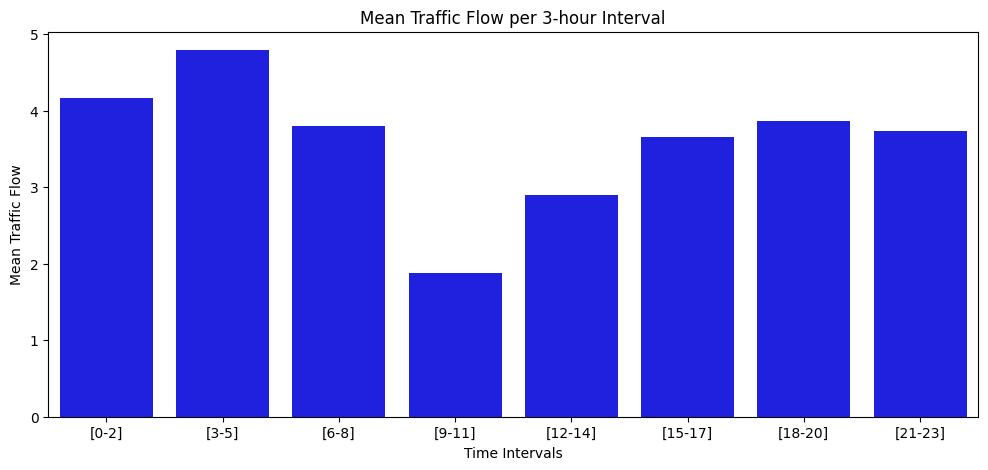

In [30]:
# Group by 3hour_interval and calculate the mean of the traffic flow
grouped_df = traffic_flow['Traffic Flow'].groupby(traffic_flow['3hour_interval']).mean()

# Add results to dataframe
grouped_df = pd.DataFrame(grouped_df,index=grouped_df.index)

# Define the intervals (use strings for easy understanding)
intervals = ['[0-2]','[3-5]','[6-8]','[9-11]','[12-14]','[15-17]','[18-20]','[21-23]']
grouped_df['Hour Interval'] = intervals

# Create a plot to view the results
plt.figure(figsize=(12,5))
sns.barplot(grouped_df, x='Hour Interval', y='Traffic Flow', color='blue')
plt.xlabel('Time Intervals')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow per 3-hour Interval')

# Show graph
plt.show()

The graph suggests that traffic flow peaks during morning and evening hours, while it tends to be lower during the noon period.

Text(0.5, 1.0, 'Mean Traffic Flow per Day of Week')

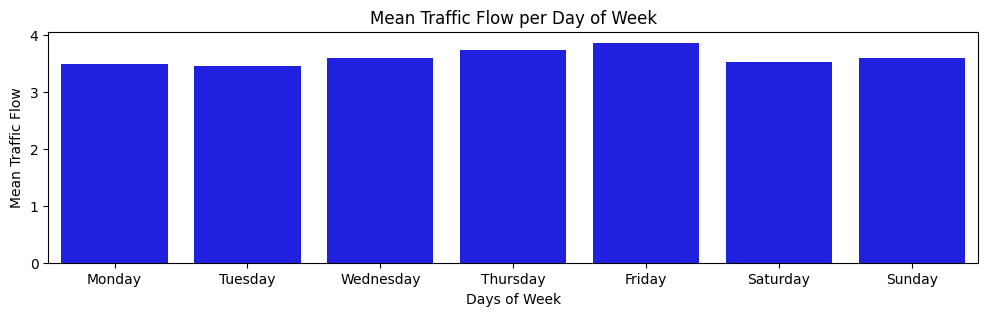

In [31]:
# Group by dayofweek and calculate the mean of the traffic flow
grouped_df = pd.DataFrame(traffic_flow['Traffic Flow'].groupby(traffic_flow['dayofweek']).mean())
grouped_df['Days'] = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Create a plot to view the results
plt.figure(figsize=(12,3))
sns.barplot(grouped_df,x='Days',y='Traffic Flow',color='blue')
plt.xlabel('Days of Week')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow per Day of Week')

According to the plot above, the average traffic flow throughout the weekdays appears to be nearly uniform. However, Thursdays and Fridays exhibit a higher average traffic flow, while the remaining days also adhere to similar patterns.

Text(0.5, 1.0, 'Mean Traffic Flow during  Memorial Day (26th of May 2008)')

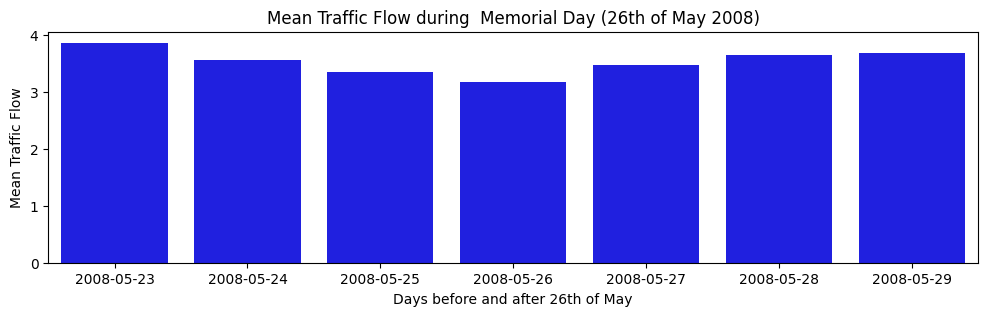

In [32]:
# Select data within the specified date range
select_data = traffic_flow[(traffic_flow['Time Column'] >= '2008-05-23') & (traffic_flow['Time Column'] < '2008-05-30')]
# Extract the date portion from the 'Time Column' and create a new 'Date' column
select_data['Date'] = select_data['Time Column'].dt.date
# Create a DataFrame by grouping 'Traffic Flow' by 'Date' and calculating the sum
select_data = pd.DataFrame(select_data['Traffic Flow'].groupby(select_data['Date']).mean())

# Create a plot to visualize the results
plt.figure(figsize=(12, 3))  # Set the size of the plot figure
sns.barplot(data=select_data, x=select_data.index, y='Traffic Flow',color='blue')
plt.xlabel('Days before and after 26th of May')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow during  Memorial Day (26th of May 2008)')

According to the calendar, Memorial Day in the United States fell on May 26, 2008. The graph above indicates that on this particular day, there was a decrease in traffic flow, while the subsequent days showed higher traffic flow.

On Memorial Day, many businesses are closed, schools may be out, and people often take the opportunity to engage in various leisure activities or travel. As a result, there tends to be a decrease in local commuting and traffic flow on that specific day compared to the surrounding days.

Text(0, 0.5, 'Mean Traffic Flow')

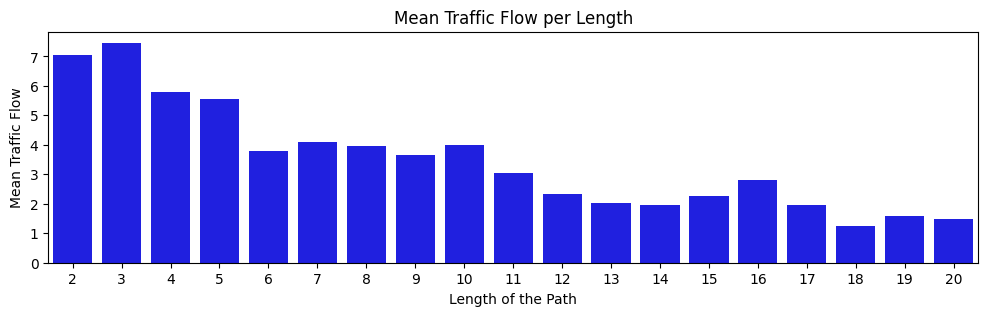

In [33]:
# Create a DataFrame by grouping 'Traffic Flow' by 'Length' and calculating the mean
group_by_length = pd.DataFrame(traffic_flow['Traffic Flow'].groupby(traffic_flow['Length']).mean())

# Create a plot to view the results
plt.figure(figsize=(12,3))
sns.barplot(group_by_length,x=group_by_length.index,y='Traffic Flow',color='blue')
plt.xlabel('Length of the Path')
plt.title('Mean Traffic Flow per Length')
plt.ylabel('Mean Traffic Flow')

The graph illustrates a trend where traffic flow tends to decrease with an increase in the length of the path. This pattern is expected, as a greater number of edges in a path makes it more challenging for a Yellow Taxi to precisely navigate that specific route.

#### **Define the spliding window length using the XGBoost model**

In [34]:
print(f"Earlier timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].min()}")
print(f"Latest timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].max()}")

Earlier timestamp in traffic_flow dataframe is: 2008-05-17 10:00:04
Latest timestamp in traffic_flow dataframe is: 2008-05-29 23:30:04


**Train and Test split of the dataset**

In this step, we split the data into two datasets, train and test.
- Train dataset contains all the data for each path till 08-06-2008 inclusive.
- The rest of the data (the most resent ones) are in the test dataset

In [35]:
# Sort the time series data
traffic_flow.sort_values(by=['Path','Time Column'], inplace=True)

In [36]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-05-29']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-05-29']

# Print the results
print("Traffic flow train set shape: ",train.shape)
print("Traffic flow test set shape: ",test.shape)

Traffic flow train set shape:  (556000, 23)
Traffic flow test set shape:  (48000, 23)


**Find the best lookback timesteps for our XGBoost model**

In this step, we define the optimum lookback timestep number for our sliding window. This optimum number will be used by the model for forecasting.

In [37]:
# Find best lookback timesteps to perform analysis on traffic_flow dataset. Save those scores in a separate dataframe
lookback_scores = pd.DataFrame(columns=['#Timesteps','XGBoost Score'])
lookback_scores['#Timesteps'] = 0
lookback_scores['XGBoost Score'] = 0

**Create function that converts the data into a supervised problem**

Consider for each path n_in timesteps of observations in the past, in order to predict the n_out timesteps in the future.

In [38]:
import pandas as pd

def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Record %d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Generate sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Record %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Record %d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data, n_in=1, n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the columns.
    """
    new_data = pd.DataFrame()

    # Iterate over unique values in the 'Path' column
    for item in data['Path'].unique():
        # Call function only for the 'Traffic Flow' column
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # Concatenate the rest of the columns
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, traffic_flow[traffic_flow['Path'] == item]], axis=1)

        new_data = pd.concat([new_data, supervised_traffic_flow])

    # Drop rows with NaN values
    new_data.dropna(inplace=True)
    return new_data

In [39]:
# Import libraries to use XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

Create a loop. In each loop, we are doing the following:
- 0. Convert train and test sets into supervised problems with lookback timesteps.
- 1. Define features and labels.
- 2. Train the XGboost model with defult parameters.
- 3. Predict on the test set.
- 4. Save RMSE in a dataframe.

In [40]:
for lookback in [2, 3, 4, 5, 6]:  # Use different lookback sizes

    # Convert train and test data to supervised
    train_s = generate_X_y_pairs(train, lookback)
    test_s = generate_X_y_pairs(test, lookback)

    print("Lookback = " + str(lookback) + " - To supervised: Completed!")

    # Add rolling mean information
    train_s['rolling_mean'] = train_s.iloc[:, 0:lookback].mean(axis=1)
    test_s['rolling_mean'] = test_s.iloc[:, 0:lookback].mean(axis=1)

    # Define features
    features_s = train_s.drop(['Traffic Flow', 'Record 1(t)', 'Time Column'], axis=1).columns

    # Define label
    labels_s = ['Record 1(t)']

    # Create X_train and y_train datasets
    X_train_s = train_s[features_s]
    y_train_s = train_s[labels_s]

    # Create X_test and y_test datasets
    X_test_s = test_s[features_s]
    y_test_s = test_s[labels_s]

    print("Lookback = " + str(lookback) + " - Train and Test sets: Completed!")

    # Define XGBoost regression model
    reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, early_stopping_rounds=5)

    # Train the XGBoost model with feature weights (use validation set on test data)
    reg.fit(X_train_s, y_train_s, eval_set=[(X_train_s, y_train_s), (X_test_s, y_test_s)], verbose=False)

    print("Lookback = " + str(lookback) + " - Training: Completed!")

    # Make predictions
    y_pred_s = reg.predict(X_test_s)

    # Calculate RMSE score
    rmse = mean_squared_error(y_test_s, y_pred_s, squared=False)

    # Create a new row as a dictionary
    new_row = {'#Timesteps': lookback, 'XGBoost Score': rmse}

    # Append the new row to the DataFrame
    lookback_scores = lookback_scores.append(new_row, ignore_index=True)

    print("Lookback = " + str(lookback) + " - Saved Results: Completed!")

Lookback = 2 - To supervised: Completed!
Lookback = 2 - Train and Test sets: Completed!
Lookback = 2 - Training: Completed!
Lookback = 2 - Saved Results: Completed!
Lookback = 3 - To supervised: Completed!
Lookback = 3 - Train and Test sets: Completed!
Lookback = 3 - Training: Completed!
Lookback = 3 - Saved Results: Completed!
Lookback = 4 - To supervised: Completed!
Lookback = 4 - Train and Test sets: Completed!
Lookback = 4 - Training: Completed!
Lookback = 4 - Saved Results: Completed!
Lookback = 5 - To supervised: Completed!
Lookback = 5 - Train and Test sets: Completed!
Lookback = 5 - Training: Completed!
Lookback = 5 - Saved Results: Completed!
Lookback = 6 - To supervised: Completed!
Lookback = 6 - Train and Test sets: Completed!
Lookback = 6 - Training: Completed!
Lookback = 6 - Saved Results: Completed!


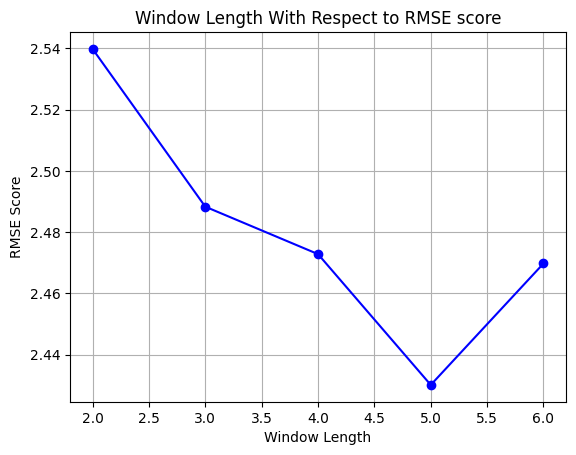

In [41]:
# Use a plot to show the results
plt.plot(lookback_scores['#Timesteps'], lookback_scores['XGBoost Score'], linestyle='-', marker='o', color='b')

# Set plot title and axis labels
plt.title('Window Length With Respect to RMSE score')
plt.xlabel('Window Length')
plt.ylabel('RMSE Score')

# Add gridlines
plt.grid(True)

# Show the plot
plt.show()

In [42]:
# Find the timesteps corresponding to the minimum RMSE score
optimum_lookback = int(lookback_scores['#Timesteps'].loc[lookback_scores['XGBoost Score'].idxmin()])

In [43]:
# Print optimum length of sliding window
print(f'Optimum length of sliding window is: {optimum_lookback}')

Optimum length of sliding window is: 5


In [44]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

**Extract features about trend of time series**

In this step we define the rolling mean and rolling variance of a window. Since we are trying to forecast the last value of each window, only the first optimum_lookback values in the window are used to compute rolling features. The last value (that we are trying to forecast) is not included.

In [45]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:optimum_lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

**Define labels and features**

Usage of a correlation matrix to delete highly correlated data

<Axes: >

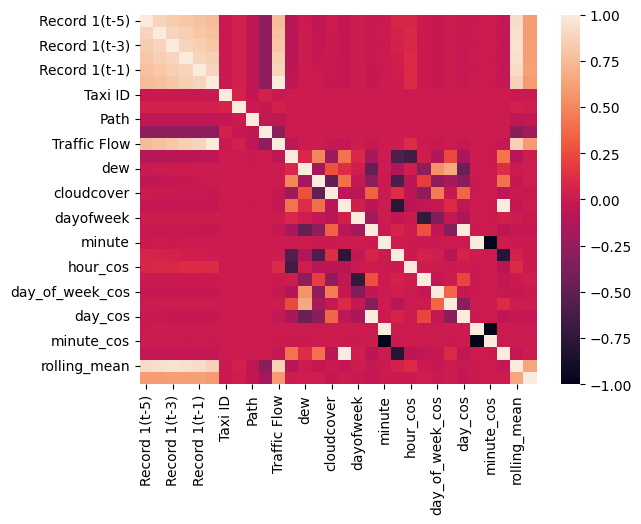

In [46]:
# Use a correlation matrix to show correlations among attributes in the dataset
sns.heatmap(train.corr(),cmap='rocket')

In [47]:
# Define a list with the items to be removed
removable_items = ['Record 1(t)', 'Time Column', 'Taxi ID', 'Traj ID', 'Length', 'Traffic Flow', 'hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute', 'minute_cos']

In [48]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

In [49]:
# Show shape information about X and y training and testing sets
print("Shape of X_train is: ",X_train.shape)
print("Shape of y_train is: ",y_train.shape)
print("Shape of X_test is: ",X_test.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of X_train is:  (551000, 18)
Shape of y_train is:  (551000, 1)
Shape of X_test is:  (43000, 18)
Shape of y_test is:  (43000, 1)


**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [50]:
# Import Grid Search library
from sklearn.model_selection import GridSearchCV

In [51]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [50],
    "learning_rate": [0.1],
    "max_depth": [3,6],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        verbose=1,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[0]	validation_0-rmse:5.45465	validation_1-rmse:5.38651
[1]	validation_0-rmse:5.06727	validation_1-rmse:4.99776
[2]	validation_0-rmse:4.72938	validation_1-rmse:4.65444
[3]	validation_0-rmse:4.43256	validation_1-rmse:4.35166
[4]	validation_0-rmse:4.17288	validation_1-rmse:4.09078
[5]	validation_0-rmse:3.94781	validation_1-rmse:3.86477
[6]	validation_0-rmse:3.74876	validation_1-rmse:3.66576
[7]	validation_0-rmse:3.58062	validation_1-rmse:3.49385
[8]	validation_0-rmse:3.43582	validation_1-rmse:3.34787
[9]	validation_0-rmse:3.31085	validation_1-rmse:3.22321
[10]	validation_0-rmse:3.20505	validation_1-rmse:3.11525
[11]	validation_0-rmse:3.11538	validation_1-rmse:3.02772
[12]	validation_0-rmse:3.03800	validation_1-rmse:2.95243
[13]	validation_0-rmse:2.97291	validation_1-rmse:2.88743
[14]	validation_0-rmse:2.91820	validation_1-rmse:2.83191
[15]	validation_0-rmse:2.87152	validation_1-rmse:2.78741
[16]	validation_0-rmse:2.83091	valida

#### **Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [52]:
# Create dataframe to save actual values and model predictions
total_predictions = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
total_predictions['Actual'] = y_test['Record 1(t)'].values
total_predictions['Path'] = X_test['Path'].values

In [54]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=True)

[0]	validation_0-rmse:5.42279	validation_1-rmse:5.35825
[1]	validation_0-rmse:5.01379	validation_1-rmse:4.94609
[2]	validation_0-rmse:4.65517	validation_1-rmse:4.58789
[3]	validation_0-rmse:4.34203	validation_1-rmse:4.27465
[4]	validation_0-rmse:4.06899	validation_1-rmse:4.00296
[5]	validation_0-rmse:3.83340	validation_1-rmse:3.76577
[6]	validation_0-rmse:3.62882	validation_1-rmse:3.56431
[7]	validation_0-rmse:3.45404	validation_1-rmse:3.39241
[8]	validation_0-rmse:3.30358	validation_1-rmse:3.24526
[9]	validation_0-rmse:3.17571	validation_1-rmse:3.11941
[10]	validation_0-rmse:3.06702	validation_1-rmse:3.01311
[11]	validation_0-rmse:2.97530	validation_1-rmse:2.92318
[12]	validation_0-rmse:2.89744	validation_1-rmse:2.85003
[13]	validation_0-rmse:2.83232	validation_1-rmse:2.78632
[14]	validation_0-rmse:2.77789	validation_1-rmse:2.73343
[15]	validation_0-rmse:2.73065	validation_1-rmse:2.68850
[16]	validation_0-rmse:2.69068	validation_1-rmse:2.65287
[17]	validation_0-rmse:2.65646	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Figure size 1500x500 with 0 Axes>

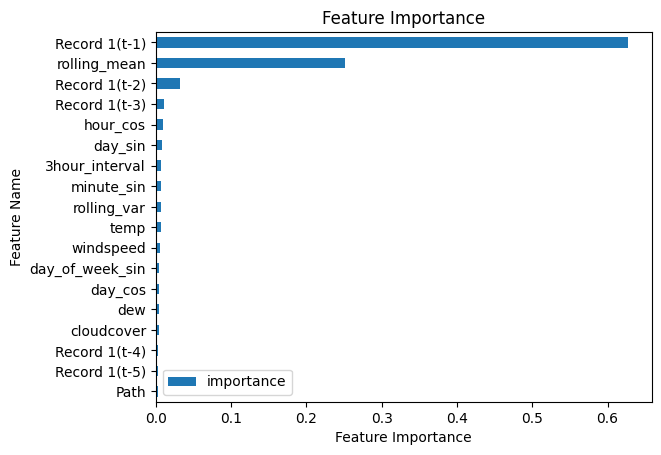

In [55]:
# Show how much each of the features was used in our regression analysis
plt.figure(figsize=(15,5))
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

Plot train and validation errors of XGBoost model in the same graph

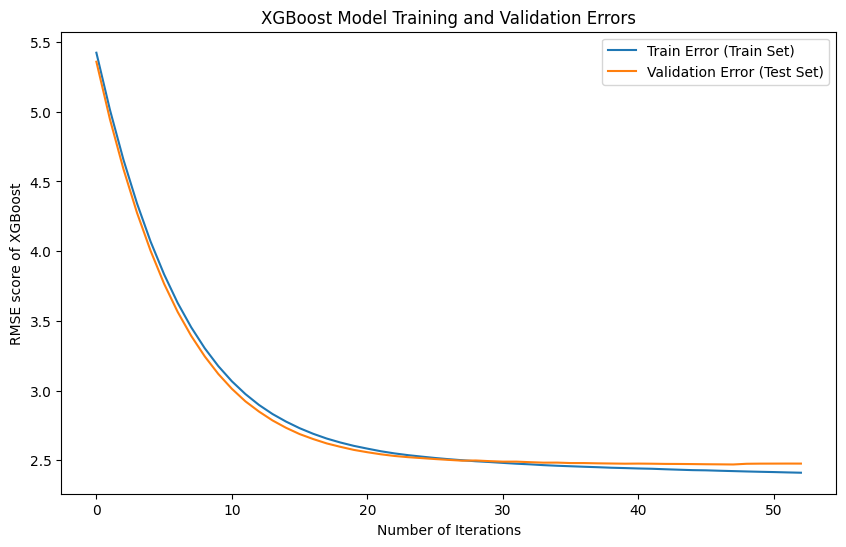

In [56]:
# Acquire the values of train and validation errors
results = reg.evals_result()
train_errors = results['validation_0']['rmse']
validation_errors = results['validation_1']['rmse']

# Plot the validation and training errors
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train Error (Train Set)')
plt.plot(validation_errors, label='Validation Error (Test Set)')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE score of XGBoost')
plt.title('XGBoost Model Training and Validation Errors')
plt.legend()
plt.show()

Make predictions on the test set

In [57]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.4727634032517671
RMSE score: 2.4705073204143755


Show example of how well the model learned the trainning data.


Use a random path to visualize the results

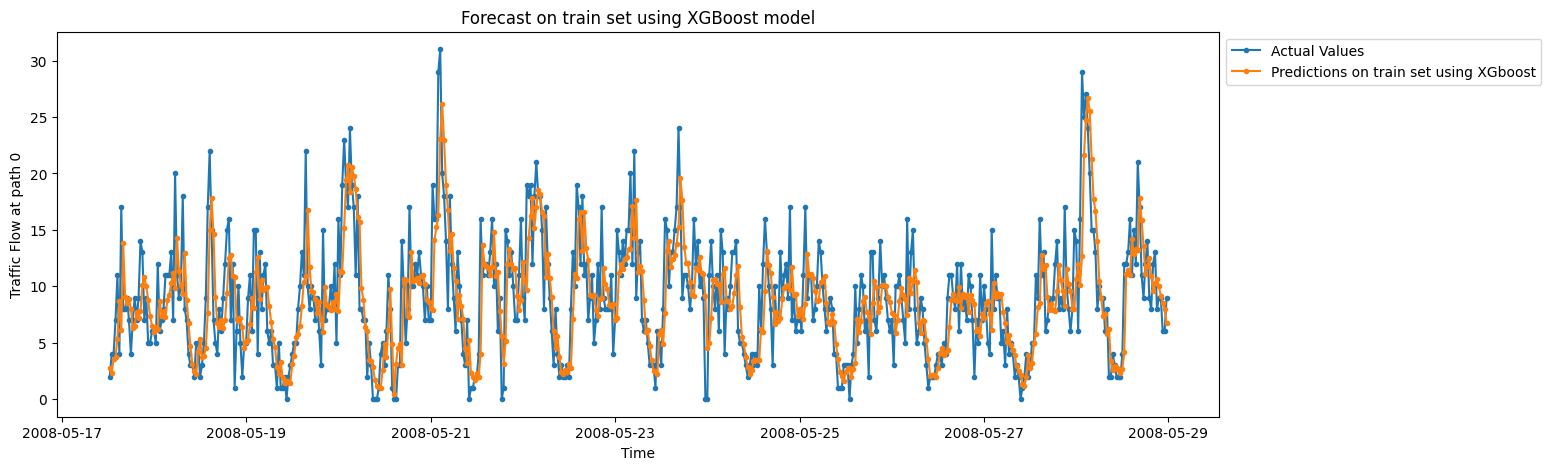

In [59]:
# Predict on the trainning set
y_pred_train = reg.predict(X_train)

# Add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Record 1(t)'].values)
train_predictions.insert(1,'Train Predicted',y_pred_train)
train_predictions.insert(2,'Path',X_train['Path'].values)

# Plot an example of the train-predictions at path 0 of the datase
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0]['Train Actual'],".-",label='Actual Values')
plt.plot(train_predictions[train_predictions['Path']==0]['Train Predicted'],".-",label='Predictions on train set using XGboost')
plt.xlabel('Time')
plt.ylabel('Traffic Flow at path 0')
plt.title('Forecast on train set using XGBoost model')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

As we can see, the model has learned the trend and (almost) the seasonality of the data.

Despite the non-linearity of Traffic Flow, XGBoost performs quite well!

#### **Train LSTM for time series forecasting**
This is the second model that we will train on the same dataset. We use the optimum lookback score that we computed above, before training the XGboost algorithm. This ensures that the LSTM model will be trained on the same data as the XGboost algorithm.

In [60]:
# Import library for data scaling
from sklearn.preprocessing import MinMaxScaler

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [61]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [62]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [63]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In [64]:
# Print shapes of the created sets
trainX.shape, trainY.shape, testX.shape, testY.shape

((551000, 1, 18), (551000, 1, 1), (43000, 1, 18), (43000, 1, 1))

Use the LSTM model for forecasting

In [65]:
# Import libraries and define the LSTM structure
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [66]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

In [67]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [68]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          verbose=1,
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 19s 127ms/step - loss: 0.0080 - val_loss: 0.0116
Epoch 2/50
100/100 [==============================] - 12s 118ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 3/50
100/100 [==============================] - 14s 137ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 4/50
100/100 [==============================] - 12s 117ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 5/50
100/100 [==============================] - 14s 139ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 6/50
100/100 [==============================] - 13s 129ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 7/50
100/100 [==============================] - 12s 121ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 8/50
100/100 [==============================] - 12s 116ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 9/50
100/100 [==============================] - 11s 115ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 10/50
100/100 [==============================] - 11s 115ms/step - l

In [69]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1344/1344 [==============================] - 8s 6ms/step - loss: 0.0030
Test Loss: 0.002986057661473751


Plot train vs. validation loss of LSTM model

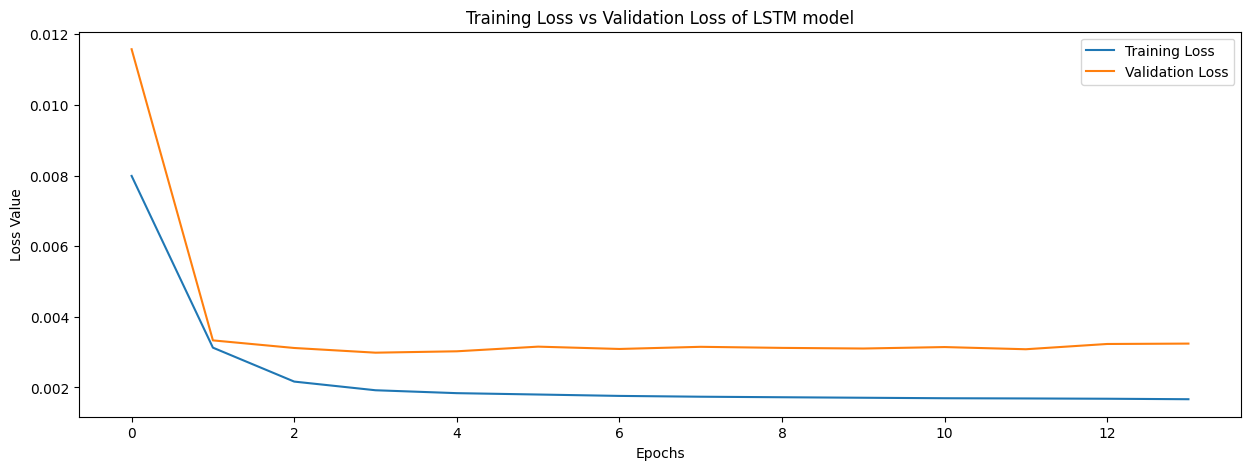

In [70]:
# Extract training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plt.figure(figsize=(15,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Training Loss vs Validation Loss of LSTM model')
plt.legend()

# Show the plot
plt.show()

In [71]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1344/1344 [==============================] - 12s 9ms/step


Evaluate the LSTM model

In [72]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.5925055138330126
RMSE LSTM score: 2.732241672540031


17219/17219 [==============================] - 112s 6ms/step


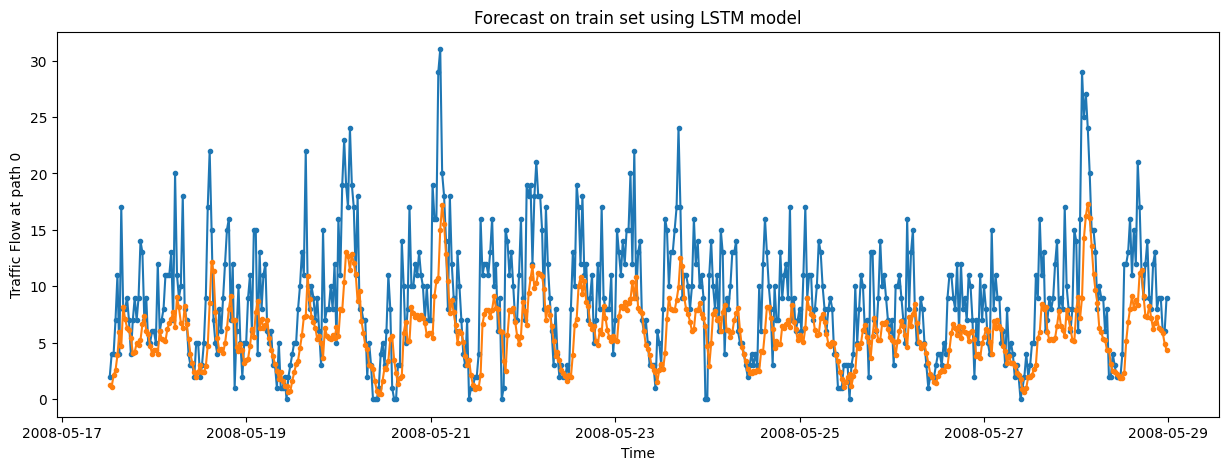

In [73]:
# Predict on the trainning set
y_pred_train_LSTM = model.predict(trainX)

# add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Record 1(t)'].values)
train_predictions.insert(1,'Train Predicted',scaler.inverse_transform(y_pred_train_LSTM.reshape(-1,1)))
train_predictions.insert(2,'Path',X_train['Path'].values)

# Plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0][['Train Actual','Train Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow at path 0')
plt.title('Forecast on train set using LSTM model')
plt.show()

#### Show results of two models

In [74]:
# Store predictions of XGBoost model to a dataframe
total_predictions['Predicted XGBoost'] = y_pred_xgboost

In [75]:
# Store predictions of LSTM model to a dataframe
total_predictions['Predicted LSTM'] = y_pred_lstm.reshape(-1,1)

In [76]:
# Print dataframe with predictions
total_predictions

,Actual,Path,Predicted XGBoost,Predicted LSTM
Time Column,,,,
2008-05-29 02:30:04,16.0,0,24.270109,19.334925
2008-05-29 03:00:04,21.0,0,19.532337,16.412277
2008-05-29 03:30:04,12.0,0,20.681408,16.516027
2008-05-29 04:00:04,25.0,0,16.991980,12.747200
2008-05-29 04:30:04,20.0,0,20.920866,15.816179
...,...,...,...,...
2008-05-29 21:30:04,9.0,999,5.132930,4.359704
2008-05-29 22:00:04,7.0,999,6.232114,5.746838
2008-05-29 22:30:04,4.0,999,6.742729,5.740690


[]

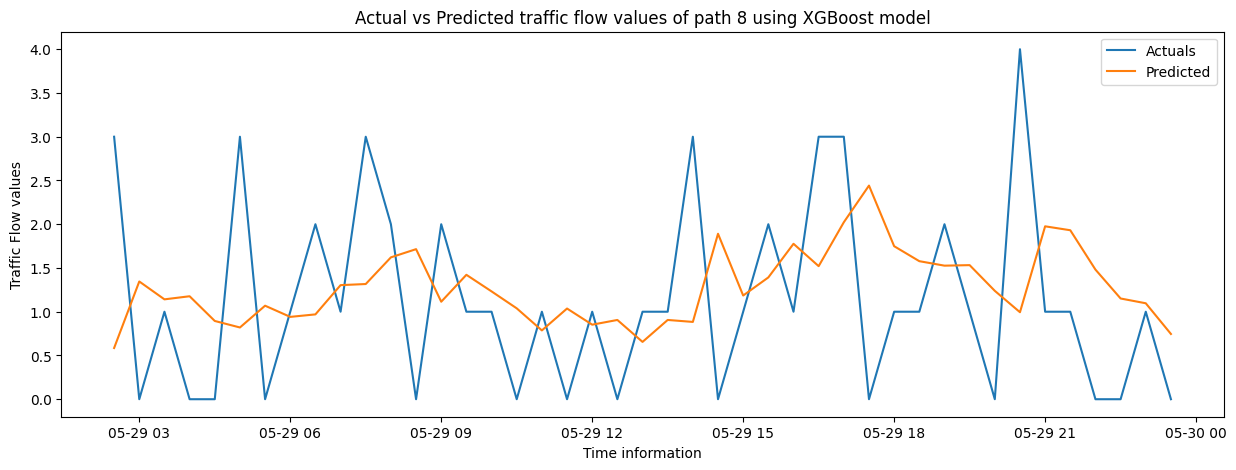

In [77]:
# Plot predictions from XGBoost model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==8]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==8]['Predicted XGBoost'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 8 using XGBoost model')
plt.legend()
plt.plot()

[]

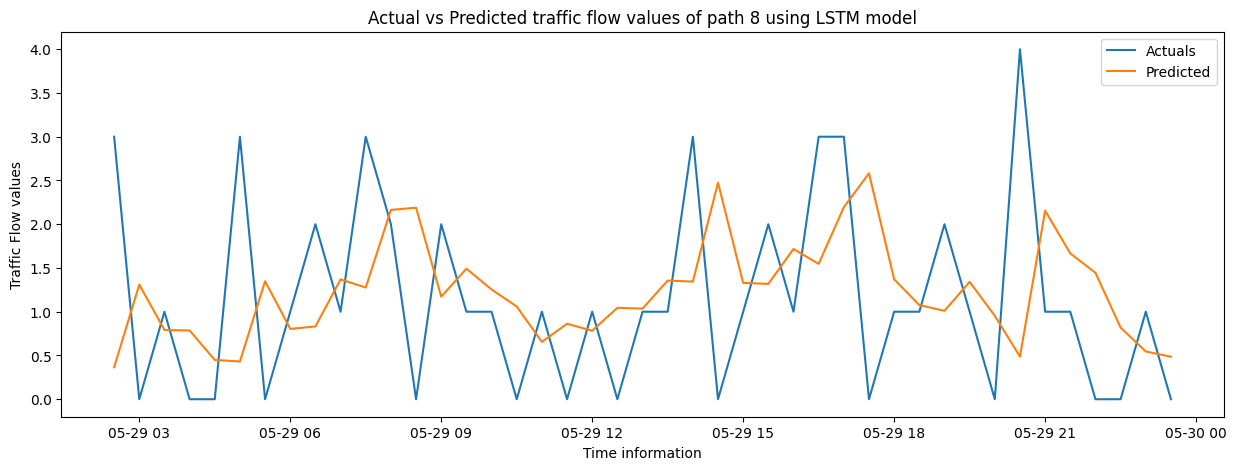

In [78]:
# Plot predictions from LSTM model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==8]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==8]['Predicted LSTM'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 8 using LSTM model')
plt.legend()
plt.plot()

[]

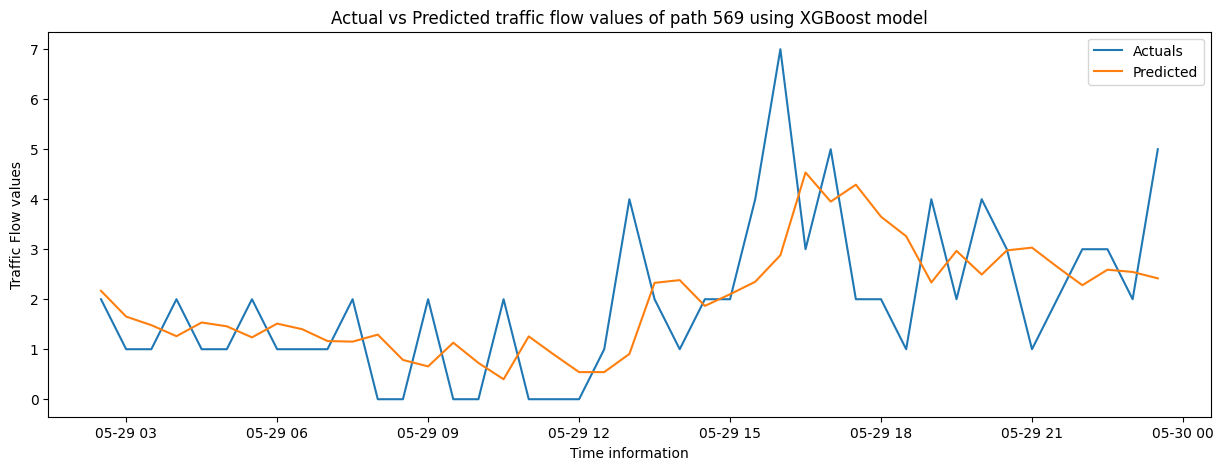

In [79]:
# Plot predictions from XGBoost model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==569]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==569]['Predicted XGBoost'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 569 using XGBoost model')
plt.legend()
plt.plot()

[]

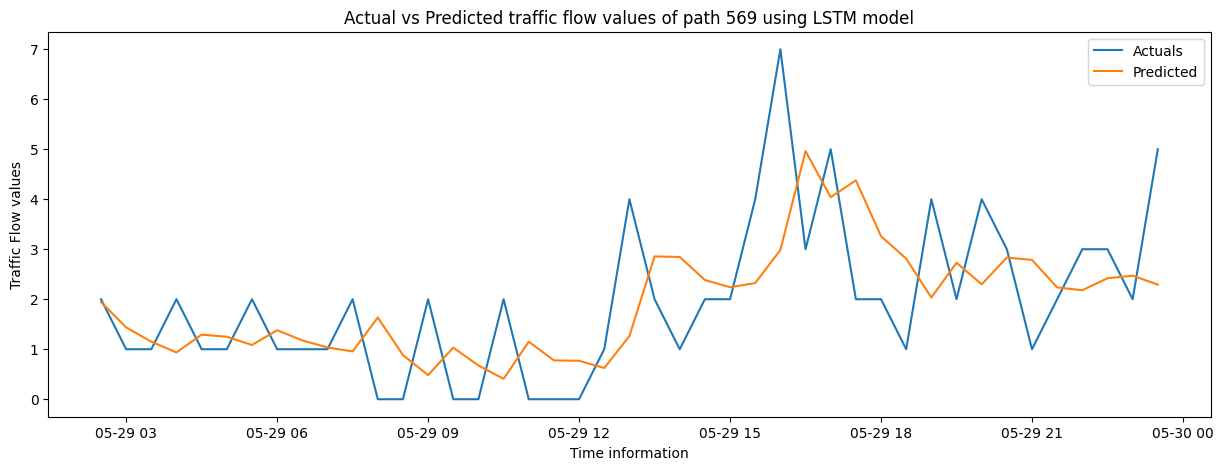

In [80]:
# Plot predictions from LSTM model
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==569]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==569]['Predicted LSTM'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 569 using LSTM model')
plt.legend()
plt.plot()

Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [81]:
# Create dataframe with scores
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [82]:
# Print dataframe with all model scores
scores

,Model,RMSE Score,MAE Score
0,XGBoost,2.470507,1.472763
1,LSTM,2.732242,1.592506


In [83]:
# Save the best model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow.model')